### code adapted from http://neuralnetworksanddeeplearning.com/chap1.html

In [88]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pnd

import numpy as np
import random

In [89]:
"""load data"""
with open('dataraw/training.csv','rb') as f_in:
    train = pnd.read_csv(f_in)
with open('dataraw/test.csv','rb') as f_in:
    test = pnd.read_csv(f_in)

In [94]:
"""set aside dev data"""
test_data = test
train_labels, train_data = train.iloc[:,:30], train.iloc[:,30:]

dev_data, dev_labels = train_data[5000:], train_labels.iloc[5000:]
train_data, train_labels = train_data[:5000], train_labels[:5000]
print train_labels.shape, train_data.shape

(5000, 30) (5000, 1)


In [182]:
"""Face Feature Id Columns"""
face = {
'left_eye':(0,1),
'right_eye' : (2,3),
'nose' : (20,21),
'bottom_lib' : (28,29)
    }

In [191]:
def xy_to_index(x_coord, y_coord, rows=96, cols=96):
    """ assumes 0 index on both x and y axes """
    x_coord, y_coord = int(x_coord), int(y_coord)
    index = x_coord + cols * y_coord
    if x_coord >= cols or y_coord >= rows:
        raise Exception('Index not within image limits', index)
    return int(index)

def index_to_xy(index, rows=96, cols=96):
    y,x = divmod(index, cols)
    return (x,y)

In [238]:
def convert_images_to_arrays(image_data):
    out = []
    for d in image_data:
        out.append(np.array([int(i) for i in d.split()]))
    return np.array(out)

def convert_labels_to_vectors(label_data, label_index):
    out = []
    for i in xrange(len(label_data)):
        tmp = np.zeros(9216)
        lab_x, lab_y = label_data.iloc[i, label_index[0]], label_data.iloc[i, label_index[1]]
        answer = xy_to_index(lab_x, lab_y, 96, 96)
        tmp[answer] = 1
        out.append(tmp)
    return np.array(out)

In [ ]:
# CONVERT TRAINING DATA

nose_train_labels = convert_labels_to_vectors(train_labels, face['nose'])
print 'train labels done'
nose_dev_labels = convert_labels_to_vectors(dev_labels, face['nose'])
print 'dev labels done'
train_images = convert_images_to_arrays(train_data['Image'])
print 'train images done'
dev_images = convert_images_to_arrays(dev_data['Image'])
print 'dev images done'

plt.imshow(train_images[0].reshape(96,96), cmap='gray')

###Simple Neural Network

In [273]:
class Network(object):
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(y,1) for y in sizes[1:]]
        self.weights = [np.random.randn(y,x) for y,x in zip(sizes[1:], sizes[:-1])]

In [274]:
def sigmoid(z):
    return float(1)/(float(1) + np.exp(-z))

In [303]:
class FFNetwork(Network):
    def __init__(self, sizes):
        super(FFNetwork, self).__init__(sizes)
        
    def feedforward(self, a):
        for w,b in zip(self.weights, self.biases):
            a = sigmoid(np.dot(w,a) + b)
        return a
    
    def SGD(self, training_data, epochs, batch_size, eta, test_data=None):
        if test_data: n_test = len(test_data)
        
        n = len(training_data)
        
        for i in xrange(epochs):
            random.shuffle(training_data)
            batches = [training_data[k:k+batch_size] for k in xrange(0,n,batch_size)]
            for batch in batches:
                self.update_batch(batch, eta)
            if test_data:
                print "Epoch {0}: {1} / {2}".format(
                    i, self.evaluate(test_data), n_test)
            else:
                print "Epoch {0} complete".format(i)
                
    def update_batch(self, batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        for x,y in batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x,y)
            nabla_b = [nb + dnb for nb,dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw,dnw in zip(nabla_w, delta_nabla_w)]            
        self.weights = [w - (eta/len(batch)) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta/len(batch)) * bw for b, bw in zip(self.biases, nabla_b)]
        
        
    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            print w.shape, activation.shape, b.shape,'|',
            z = np.dot(w, activation)+b
            print z.shape,
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            print activation.shape
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        print output_activations
        print y
        return (output_activations-y)

In [304]:
#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print "Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test)
            else:
                print "Epoch {0} complete".format(j)

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

####LOAD FACE DATA
    We're going to try to find noses first

nose_tip_x    48.909088
nose_tip_y    62.455982
Name: 5000, dtype: float64


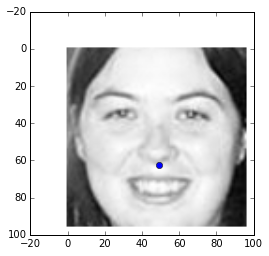

In [300]:
# render one dev face
ix = 0

print dev_labels.iloc[ix,20:22]
face_list = [int(i) for i in dev_data['Image'].iloc[ix].split()]
face = np.array(face_list).reshape(96,96)
plt.imshow(face, cmap='gray')
plt.plot(dev_labels.iloc[ix,20], dev_labels.iloc[ix,21], 'bo')
plt.show()


In [305]:
net = Network([9216,1000,9216])
# print [n.shape for n in net.weights]
# print [n.shape for n in net.biases]

net.SGD(zip(train_images[:100], nose_train_labels[:100]), 30, 25, 3.0, zip(dev_images[:30], nose_dev_labels[:30]))

ValueError: operands could not be broadcast together with shapes (9216,1000) (9216,) 